In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test_x.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [ ]:
train.shape, test.shape, submission.shape

# 2. EDA & 전처리

In [ ]:
df = pd.concat([train, test])
df.shape

In [ ]:
train.info

## Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

## 컬럼 분류

In [4]:
data = []

for f in train.columns:
    dtl = ''
    if f == 'voted':
        gubun = 'target'
    elif 'Q' in f:
        dtl = f[1]
        if 'A' in f:
            gubun = 'Q_A'
        if 'E' in f:
            gubun = 'Q_E'
    elif 'tp' in f:           
        gubun = 'tp'            
    elif 'wf' in f:           
        gubun = 'wf'
    elif 'wr' in f:           
        gubun = 'wr'    
    else:
        gubun = 'cat'
        
    f_dict = {
        'col':f,
        'gbn':gubun,
        'dtl':dtl
    }
            
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns =['col', 'gbn', 'dtl'])
meta.set_index('col', inplace=True)
meta

,gbn,dtl
col,,
QaA,Q_A,a
QaE,Q_E,a
QbA,Q_A,b
QbE,Q_E,b
QcA,Q_A,c
...,...,...
wr_09,wr,
wr_10,wr,
wr_11,wr,


## CovariateShift

In [5]:
train['race']=pd.factorize(train['race'])[0]
test['race']=pd.factorize(test['race'])[0]

train = pd.get_dummies(train, columns=['race'])
test = pd.get_dummies(test, columns=['race'])

train.drop(['race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6'], axis=1, inplace=True)
test.drop(['race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6'], axis=1, inplace=True)


train.drop('religion', axis=1, inplace=True)
test.drop('religion', axis=1, inplace=True)

### Q_A

In [ ]:
Q_A = meta[meta.gbn=='Q_A'].index

train[Q_A].describe()
train[Q_A].head(3)

### Q_A 1/5 count

In [ ]:
# Q_A: 1~5 1/5 극단값 선택한 count 추출
train['Q_A15'] = 0
train['Q_A3'] = 0

test['Q_A15'] = 0
test['Q_A3'] = 0

In [ ]:
%%time
for f in Q_A:
    for i, v in enumerate(train[f]):
        if v == 1:
            train.loc[i, 'Q_A15'] = train.loc[i, 'Q_A15']+1
        elif v == 3:
            train.loc[i, 'Q_A3'] = train.loc[i, 'Q_A3']+1
        elif v == 5:
            train.loc[i, 'Q_A15'] = train.loc[i, 'Q_A15']+1            

In [ ]:
%%time
for f in Q_A:
    for i, v in enumerate(test[f]):
        if v == 1:
            test.loc[i, 'Q_A15'] = test.loc[i, 'Q_A15']+1
        elif v == 3:
            test.loc[i, 'Q_A3'] = test.loc[i, 'Q_A3']+1            
        elif v == 5:
            test.loc[i, 'Q_A15'] = test.loc[i, 'Q_A15']+1                        

### Q_E

In [ ]:
Q_E = meta[meta.gbn == 'Q_E'].index

train[Q_E].describe()
train[Q_E].head()

### tp

In [6]:
# 0~7 
tp = meta[meta.gbn=='tp'].index

train[tp].describe()
train[tp].head(3)

,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,3.017241,2.621189,1.768712,3.041246,1.335918,2.472217,2.031099,3.507226,2.277497,4.317996
std,2.007713,1.897081,1.685069,2.037278,1.452544,2.000658,1.785824,1.971456,1.848783,1.722793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,3.000000
50%,3.000000,2.000000,1.000000,3.000000,1.000000,2.000000,2.000000,4.000000,2.000000,5.000000
75%,5.000000,4.000000,3.000000,5.000000,2.000000,4.000000,3.000000,5.000000,4.000000,6.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
index,,,,,,,,,,
0,2,2,2,1,2,1,7,4,4,3
1,1,1,0,0,1,2,3,4,0,4
2,2,3,1,5,3,4,2,6,1,3


In [7]:
# tp: 1,7 극단값 선택한 count 추출, 4 중간값 선택 count 
train['tp17'] = 0
train['tp4'] = 0

test['tp17'] = 0
test['tp4'] = 0

In [8]:
%%time
for f in tp:
    for i, v in enumerate(train[f]):
        if v == 1:
            train.loc[i, 'tp17'] = train.loc[i, 'tp17']+1
        elif v == 7:
            train.loc[i, 'tp17'] = train.loc[i, 'tp17']+1
        elif v == 4:
            train.loc[i, 'tp4'] = train.loc[i, 'tp4']+1            

Wall time: 41.1 s


In [9]:
%%time
for f in tp:
    for i, v in enumerate(test[f]):
        if v == 1:
            test.loc[i, 'tp17'] = test.loc[i, 'tp17']+1
        elif v == 7:
            test.loc[i, 'tp17'] = test.loc[i, 'tp17']+1
        elif v == 4:
            test.loc[i, 'tp4'] = test.loc[i, 'tp4']+1            

Wall time: 9.61 s


#### 극단값 중간값

In [ ]:
train['Q_A15tp17'] = train['Q_A15'] + train['tp17']
train['Q_A3tp4'] = train['Q_A3'] + train['tp4']

In [ ]:
test['Q_A15tp17'] = test['Q_A15'] + test['tp17']
test['Q_A3tp4'] = test['Q_A3'] + test['tp4']

In [ ]:
# 0/1
wf = meta[meta.gbn=='wf'].index
train[wf].describe()
train[wf].head(3)

In [ ]:
# 0/1
wr = meta[meta.gbn=='wr'].index
train[wr].describe()
train[wr].head(3)

## Target Encoding

### age_group

In [10]:
train['age_group_int'] = train['age_group'].str.replace('s','').astype('int')
test['age_group_int'] = test['age_group'].str.replace('s','').astype('int')

In [11]:
train['age_group_n_rows'] = train['age_group_int'].map(train.groupby('age_group_int').size())
test['age_group_n_rows'] = test['age_group_int'].map(test.groupby('age_group_int').size())

In [12]:
age_group_mean = train.groupby('age_group_int')['voted'].mean()
train['age_group_mean'] = train['age_group_int'].map(age_group_mean)
test['age_group_mean'] = test['age_group_int'].map(age_group_mean)

In [13]:
# train['voted'].mean() = 1.5468242115435298
def smoothing(n_rows, target_mean): 
    return (target_mean*n_rows + 1.5468242115435298*0.8) / (n_rows + 0.8)

In [14]:
train['age_group_mean_smoothing'] = train.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)
test['age_group_mean_smoothing'] = test.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)

In [15]:
train.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)
test.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)

### outlier

In [16]:
train = train[train.familysize < 25]

In [ ]:
train.shape, train.columns

In [ ]:
test.shape, test.columns

# 3. 모델 학습

In [ ]:
import gc
gc.collect()

In [ ]:
train.columns

In [19]:
#col_cat = meta[(meta.gbn == 'Q_A') | (meta.gbn == 'cat')].index.values.tolist()
col_cat = ['QaA',
 'QbA',
 'QcA',
 'QdA',
 'QeA',
 'QfA',
 'QgA',
 'QhA',
 'QiA',
 'QjA',
 'QkA',
 'QlA',
 'QmA',
 'QnA',
 'QoA',
 'QpA',
 'QqA',
 'QrA',
 'QsA',
 'QtA',
 'age_group',
 'education',
 'engnat',
 'familysize',
 'gender',
 'hand',
 'married',
# 'race_0',
 #'religion',
 'urban'
#,'Priority'
          ]

In [20]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'voted'
          , categorical_features=col_cat
          , numeric_features = ['race_0','tp17','tp4']#,,'Q_A15','Q_A3','Q_A15tp17','Q_A3tp4']#['Q_A1','Q_A3','Q_A5','tp17','tp4','Q_A15tp17','Q_A3tp4']
          #, ignore_features =['Priority']#'religion', 'race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"1: 0, 2: 1"
3,Original Data,"(45524, 79)"
4,Missing Values,False
5,Numeric Features,24
6,Categorical Features,54
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 2min 35s


In [21]:
best_5 = compare_models(sort = 'AUC', n_select = 5
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.6940,0.7645,0.6511,0.7556,0.6994,0.3912,0.3958,19.5295
1,CatBoost Classifier,0.6919,0.7623,0.6549,0.7499,0.6992,0.3863,0.3901,18.1996
2,Light Gradient Boosting Machine,0.6882,0.7602,0.6474,0.7484,0.6942,0.3794,0.3836,0.9803
3,Linear Discriminant Analysis,0.6862,0.7582,0.6541,0.7416,0.6951,0.3745,0.3777,0.9497
4,Extra Trees Classifier,0.6854,0.7564,0.6343,0.7516,0.6879,0.3753,0.3808,2.6082
5,Ada Boost Classifier,0.6855,0.7541,0.6500,0.7429,0.6933,0.3735,0.3771,4.6909
6,Extreme Gradient Boosting,0.6690,0.7391,0.6638,0.7115,0.6868,0.3368,0.3377,11.0499
7,Random Forest Classifier,0.6542,0.7103,0.6008,0.7204,0.6552,0.3140,0.3192,0.2917


In [22]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6965,0.7658,0.6586,0.7552,0.7036,0.3957,0.3996
1,0.7010,0.7695,0.6631,0.7596,0.7081,0.4044,0.4084
2,0.6940,0.7676,0.6462,0.7584,0.6978,0.3919,0.3971
3,0.6877,0.7623,0.6486,0.7469,0.6943,0.3784,0.3823
4,0.6933,0.7665,0.6470,0.7568,0.6976,0.3904,0.3954
Mean,0.6945,0.7664,0.6527,0.7554,0.7003,0.3922,0.3966
SD,0.0043,0.0024,0.0069,0.0045,0.0049,0.0084,0.0084


In [23]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6958,0.7639,0.6542,0.7566,0.7017,0.3947,0.3991


In [24]:
%%time
final_model = finalize_model(blended)

Wall time: 8min 35s


In [25]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [26]:
submission['voted'] = predictions['Score']

# 5. 제출

In [27]:
submission.to_csv('output/20201010-2.csv')

In [28]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7010,0.7728,0.6508,0.7671,0.7042,0.4061,0.4117
1,0.6844,0.7478,0.6459,0.7434,0.6912,0.3718,0.3757
2,0.6903,0.7591,0.6557,0.7470,0.6984,0.3829,0.3863
3,0.7060,0.7763,0.6607,0.7691,0.7108,0.4152,0.4202
4,0.6988,0.7739,0.6557,0.7605,0.7042,0.4008,0.4053
5,0.6885,0.7618,0.6459,0.7498,0.6940,0.3803,0.3847
6,0.6892,0.7656,0.6393,0.7551,0.6924,0.3828,0.3882
7,0.6928,0.7569,0.6661,0.7450,0.7033,0.3869,0.3895
8,0.7018,0.7760,0.6530,0.7669,0.7054,0.4074,0.4128
9,0.6870,0.7552,0.6374,0.7522,0.6901,0.3783,0.3836


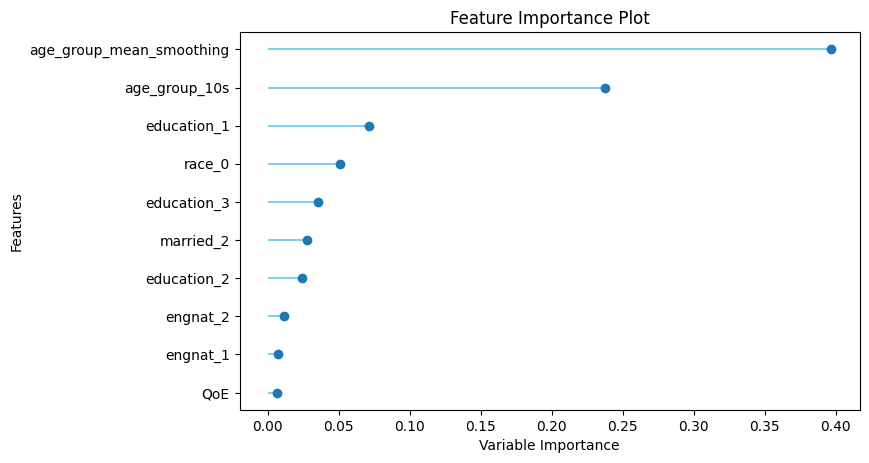

In [29]:
plot_model(estimator = gbc, plot = 'feature')

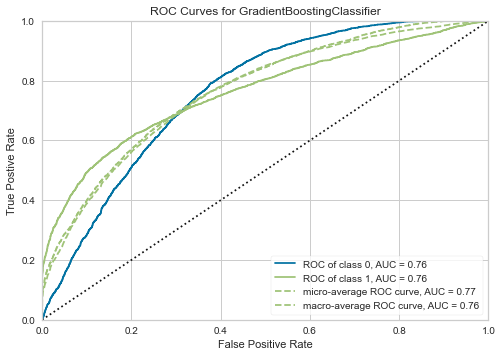

In [30]:
plot_model(estimator = gbc, plot = 'auc')

In [31]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6948,0.7632,0.6590,0.7521,0.7025,0.3919,0.3955
1,0.6831,0.7498,0.6418,0.7436,0.6890,0.3695,0.3737
2,0.6867,0.7610,0.6377,0.7517,0.6900,0.3776,0.3828
3,0.6997,0.7683,0.6557,0.7619,0.7048,0.4027,0.4074
4,0.6948,0.7665,0.6525,0.7559,0.7004,0.3927,0.3971
5,0.6876,0.7596,0.6467,0.7479,0.6936,0.3783,0.3825
6,0.6910,0.7583,0.6492,0.7521,0.6969,0.3853,0.3896
7,0.6776,0.7528,0.6456,0.7328,0.6864,0.3574,0.3604
8,0.6892,0.7720,0.6456,0.7510,0.6943,0.3819,0.3865
9,0.6771,0.7505,0.6399,0.7352,0.6842,0.3572,0.3608


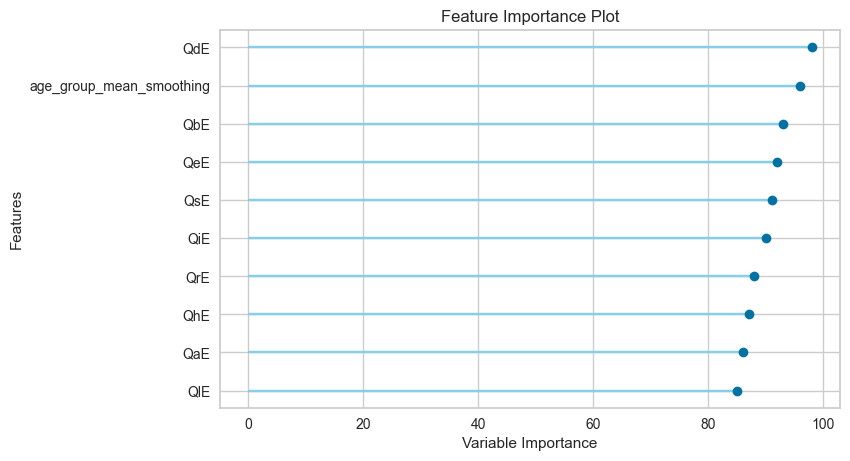

In [32]:
plot_model(estimator = lightgbm, plot = 'feature')